In [1]:
import numpy as np
import pandas as pd
from pandas import Grouper
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
db = pd.read_csv('db.csv', 
                         sep=';',
                         on_bad_lines='skip',
                         names=["TICKER", "DATE", "SIGN", "ROBERTA", "VADERS", "ADJ_CLOSE", "HIGH", "VOLUME"],
                         skiprows=1)

#db['DATE'] = pd.to_datetime(db['DATE'], format='%Y-%M-%d')
db['DATE'] = pd.to_datetime(db['DATE'], errors='coerce')

db

,TICKER,DATE,SIGN,ROBERTA,VADERS,ADJ_CLOSE,HIGH,VOLUME
2304675,A,2013-12-02,scorpio,-0.711911,0.0387,NaN,NaN,NaN
2304676,A,2013-12-03,scorpio,-0.450335,0.5859,-0.526240,-0.931611,69.748517
2304680,A,2013-12-04,scorpio,0.334660,0.8979,1.228044,1.241302,-2.469171
2304681,A,2013-12-05,scorpio,0.351063,0.7960,-0.149309,-0.055737,-25.059221
2304685,A,2013-12-06,scorpio,0.811505,0.2315,2.485975,2.100378,68.655419
...,...,...,...,...,...,...,...,...
1834702,ZYNE,2016-12-06,leo,-0.246660,0.7703,9.711682,4.571431,49.317073
1834705,ZYNE,2016-12-07,leo,-0.461272,0.3818,0.345783,0.136609,-39.268213
1834708,ZYNE,2016-12-08,leo,-0.278893,0.1531,7.029631,7.230562,74.771382
1834711,ZYNE,2016-12-09,leo,0.355984,0.6577,-2.962009,5.534350,7.510003


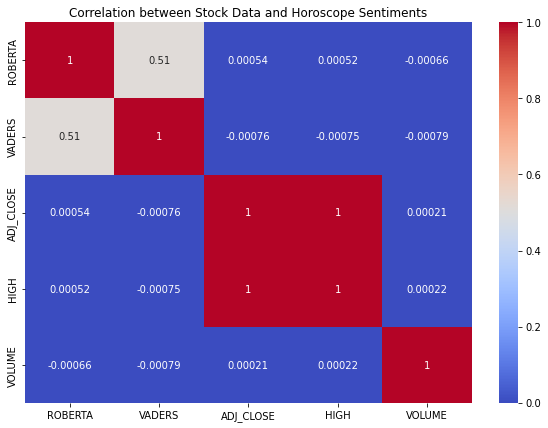

In [4]:
correlation_matrix = db[['ROBERTA', 'VADERS', 'ADJ_CLOSE', 'HIGH', 'VOLUME']].corr()
plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation between Stock Data and Horoscope Sentiments")
plt.show()

In [9]:
def compute_scores(interval):
    df2 = db.groupby(['SIGN', pd.Grouper(key='DATE', axis=0, freq=f'{interval}D')])\
            .agg({'ADJ_CLOSE':'mean', 'ROBERTA':'mean', 'VADERS':'mean'}).reset_index()
    
    df2['VADERS_CORRECT'] = np.where(df2['VADERS']*df2['ADJ_CLOSE'] > 0, 1, 0)
    df2['ROBERTA_CORRECT'] = np.where(df2['ROBERTA']*df2['ADJ_CLOSE'] > 0, 1, 0)
    
    sign_scores = df2.groupby('SIGN').agg({'VADERS_CORRECT':'sum', 'ROBERTA_CORRECT':'sum', 'DATE':'count'})
    sign_scores['VADERS_SCORE'] = sign_scores['VADERS_CORRECT']/sign_scores['DATE']
    sign_scores['ROBERTA_SCORE'] = sign_scores['ROBERTA_CORRECT']/sign_scores['DATE']
    
    return sign_scores['VADERS_SCORE'].mean(), sign_scores['ROBERTA_SCORE'].mean()


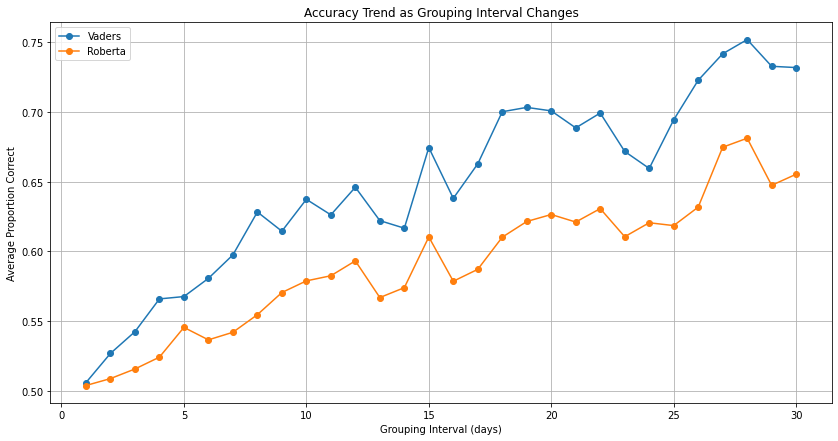

In [10]:
intervals = list(range(1, 31))
vaders_scores = []
roberta_scores = []

for interval in intervals:
    v_score, r_score = compute_scores(interval)
    vaders_scores.append(v_score)
    roberta_scores.append(r_score)

# Plotting
plt.figure(figsize=(14,7))
plt.plot(intervals, vaders_scores, label='Vaders', marker='o')
plt.plot(intervals, roberta_scores, label='Roberta', marker='o')
plt.xlabel("Grouping Interval (days)")
plt.ylabel("Average Proportion Correct")
plt.title("Accuracy Trend as Grouping Interval Changes")
plt.legend()
plt.grid(True)
plt.show()